In [19]:
"""
@auther Surajit Kundu
@RollNo 21MM91R09
@Email surajit.113125@gmail.com
"""

#import the required library
import cv2, math
import numpy as np
import matplotlib.pyplot as plt


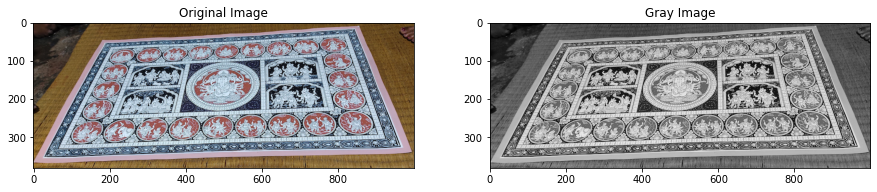

In [20]:
"""
Read images and convert to grayscale
"""
image = cv2.imread("PataChitraPuri_1.jpg")
#image = cv2.imread("PataChitraPuri2.jpg")
image_1 = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
grayImage = cv2.cvtColor(image_1, cv2.COLOR_RGB2GRAY)
plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image_1)
plt.subplot(1, 2, 2)
plt.title("Gray Image")
plt.imshow(grayImage, cmap='gray')
plt.imsave("grayImage.jpg", grayImage, cmap='gray')
plt.show()

Threshold>> 134.0


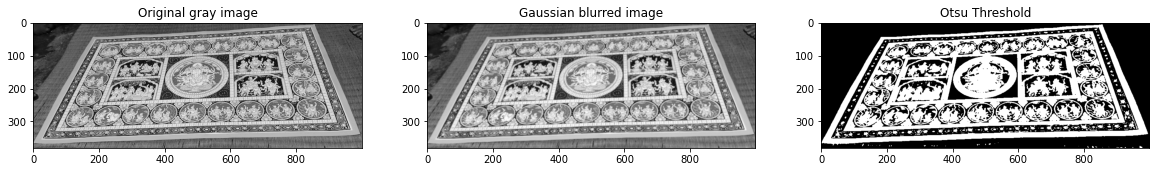

In [21]:
"""
(i) Foreground extraction of painting in an image such that only the
pixels belonging to the artwork have their original values and the
rest become zero (black). 10
"""
# Otsu's thresholding after Gaussian filtering
blur = cv2.GaussianBlur(grayImage,(5,5),1)
ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
print("Threshold>>",ret3)
plt.figure(figsize=(20,20))
plt.subplot(1, 3, 1)
plt.title("Original gray image")
plt.imshow(grayImage, cmap='gray')
plt.subplot(1, 3, 2)
plt.title("Gaussian blurred image")
plt.imshow(blur, cmap='gray')
plt.subplot(1, 3, 3)
plt.title("Otsu Threshold")
plt.imshow(th3, cmap='gray')
plt.imsave("Otsuimage.jpg", th3, cmap='gray')
plt.show()


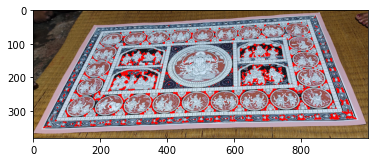

In [22]:
"""
Identifying corner points, and boundary edges. 10
"""
dst = cv2.cornerHarris(grayImage,5,3,0.04)
ret, dst = cv2.threshold(dst,0.1*dst.max(),255,0)
dst = np.uint8(dst)
# ret, labels, stats, centroids = cv2.connectedComponentsWithStats(dst)
# criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
# corners = cv2.cornerSubPix(grayImage,np.float32(centroids),(5,5),(-1,-1),criteria)
#for i in range(1, len(corners)):
    #print(corners[i])
image_temp = image_1.copy()
image_temp[dst>0.1*dst.max()]=[255,0,0]
plt.imshow(image_temp)
plt.imsave("CornerPoints.jpg",image_temp)

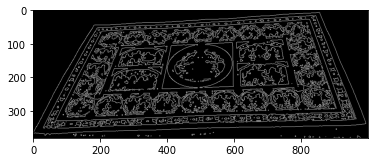

In [23]:
## Edge detection
cannyEdges = cv2.Canny(th3,100,200)
plt.imshow(cannyEdges, cmap='gray')
plt.imsave("edgesImage.jpg", cannyEdges, cmap='gray')

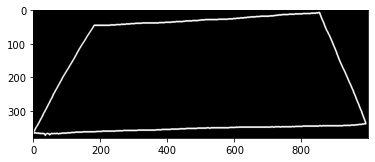

In [24]:
## Getting the outer boundary
cnts = cv2.findContours(th3, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
c = max(cnts, key=cv2.contourArea)
#print(c)
outerEdge = cv2.drawContours(np.zeros_like(th3), c, -1, 255, 3)

plt.imshow(outerEdge, cmap='gray')

[[182  43]
 [855   5]
 [995 338]
 [  0 368]]


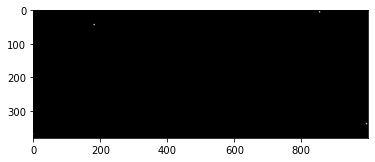

In [25]:
"""
Automatic detection of four corner points for Homography transformation
"""
def FourCornerPoints(corners):
    corners = np.reshape(corners,(len(corners), 2))
    # initialzieng the four coordinates that will be ordered such that the first entry in the list is the top-left,
    #the second entry is the top-right, the third is the bottom-right, and the fourth is the bottom-left
    rect = np.zeros((4, 2), dtype = "float32")

    # The top-left point will have the smallest sum, whereas the bottom-right point will have the largest sum
    s = corners.sum(axis = 1)
    rect[0] = corners[np.argmin(s)]
    rect[2] = corners[np.argmax(s)]

    # now, compute the difference between the points, the
    # top-right point will have the smallest difference,
    # whereas the bottom-left will have the largest difference
    diff = np.diff(corners, axis = 1)
    rect[1] = corners[np.argmin(diff)]
    rect[3] = corners[np.argmax(diff)]

    # return the ordered coordinates
    return rect

outerEdge_index = []
for col in range(outerEdge.shape[0]):
    for row in range(outerEdge.shape[1]):
        if outerEdge[col][row]>0:
            outerEdge_index.append([row, col])
#corners = cv2.goodFeaturesToTrack(outerEdge,25,0.01,10)
#corners = np.int0(corners)
fourPoints = np.int0(FourCornerPoints(outerEdge_index))
fourPoints_ = np.reshape(fourPoints, (4, 1, 2))
print(fourPoints)
plt.imshow(cv2.drawContours(np.zeros_like(outerEdge), np.array(fourPoints_),-1, 255, 3), cmap='gray')
plt.show()

In [26]:
"""
Computing homography matrix for mapping the paintings to a
target rectangle of the aspect ratio of the same as the original
image
"""
## Find the value of H
pts_src = fourPoints
pts_dst = np.array([[0,0],[th3.shape[1],0],[th3.shape[1], th3.shape[0]], [0,th3.shape[0]]])
h, status = cv2.findHomography(pts_src, pts_dst)
h

array([[ 1.79105070e+00,  1.00298839e+00, -3.69099728e+02],
       [ 1.10559432e-01,  1.95806572e+00, -1.04318643e+02],
       [ 1.85817842e-04,  1.67786106e-03,  1.00000000e+00]])

In [27]:
#Transform the image
im_out = cv2.warpPerspective(image_1, h, (outerEdge.shape[1],outerEdge.shape[0]))
image_1.shape

(381, 1000, 3)

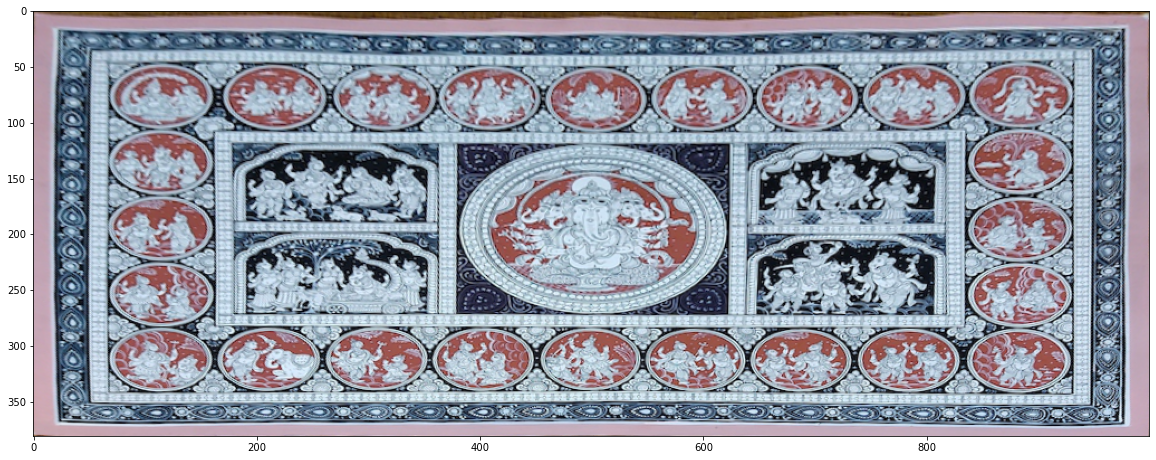

In [28]:
plt.figure(figsize=(20, 20))
plt.imshow(im_out)
plt.imsave("H_PataChitraPuri2.jpg", im_out)